In [1]:
import pandas as pd
import numpy as np
import sys, os

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/home/reza/risk_env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
lib_dir = "../"
if lib_dir not in sys.path:
    sys.path.append(lib_dir)
    
from utilities.model import Model
from utilities.binning_builder import BinningBuilder
from utilities.helper_functions import prepare_categorical_ordinal_inputs

# Import Data

In [3]:
data = pd.read_csv('../data/credit_ds_v3.csv')

In [4]:
data

X  number_of_cards  outstanding  credit_limit        bill  \
0          2                2       268691    10000000.0    254564.0   
1          3                3      6769149    28000000.0   4159779.0   
2          5                2      9402085    10000000.0   6099283.0   
3          6                2      6227439    80000000.0   2081248.0   
4          7                2      3906290     4000000.0   2043682.0   
...      ...              ...          ...           ...         ...   
15640  15584                3      6648830    25000000.0   1649598.0   
15641  15585                2     84986691    82000000.0  68369169.0   
15642  15586                2      1231919    17000000.0    239139.0   
15643  15587                3       288927    92000000.0    246511.0   
15644  15588                3      2447580     3000000.0   2367565.0   

       total_cash_usage  total_retail_usage  remaining_bill branch_code  \
0                   0.0              1012.0             0.0           A   
1                   0.0                 0.0             0.0           A   
2                   0.0           2666558.0       5951865.0           A   
3                   0.0           3690250.0       4613435.0           A   
4                   0.0            230400.0       3314046.0           A   
...                 ...                 ...             ...         ...   
15640               0.0                 0.0       3427550.0         NaN   
15641         4350000.0           4868758.0      80831676.0         NaN   
15642               0.0            993058.0             0.0         NaN   
15643               0.0                 0.0             0.0         NaN   
15644               0.0              9740.0       2458532.0         NaN   

       payment_ratio  ...  default_flag  years_since_card_issuing  \
0               0.00  ...             0                  0.750000   
1             100.00  ...             0                 10.750000   
2              95.99  ...             0                  1.666667   
3               0.00  ...             0                 10.250000   
4              18.47  ...             0                  4.666667   
...              ...  ...           ...                       ...   
15640        -100.00  ...             0                  7.830000   
15641         -17.10  ...             0                 13.000000   
15642        -100.00  ...             0                  6.580000   
15643        -100.00  ...             0                 13.100000   
15644         -99.80  ...             0                  6.580000   

       total_usage  remaining_bill_per_number_of_cards  \
0           1012.0                                 0.0   
1              0.0                                 0.0   
2        2666558.0                           2975932.5   
3        3690250.0                           2306717.5   
4         230400.0                           1657023.0   
...            ...                                 ...   
15640          0.0                           1142517.0   
15641    9218758.0                          40415838.0   
15642     993058.0                                 0.0   
15643          0.0                                 0.0   
15644       9740.0                            819511.0   

       remaining_bill_per_limit  total_usage_per_limit  \
0                      0.000000               0.000101   
1                      0.000000               0.000000   
2                      0.595186               0.266656   
3                      0.057668               0.046128   
4                      0.828511               0.057600   
...                         ...                    ...   
15640                  0.137000               0.000000   
15641                  0.986000               0.112000   
15642                  0.000000               0.058400   
15643                  0.000000               0.000000   
15644                  0.820000               0.003250   

       total_3mo_usage

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15645 entries, 0 to 15644
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   X                                   15645 non-null  int64  
 1   number_of_cards                     15645 non-null  int64  
 2   outstanding                         15645 non-null  int64  
 3   credit_limit                        15645 non-null  float64
 4   bill                                15645 non-null  float64
 5   total_cash_usage                    15600 non-null  float64
 6   total_retail_usage                  15645 non-null  float64
 7   remaining_bill                      15645 non-null  float64
 8   branch_code                         15450 non-null  object 
 9   payment_ratio                       15645 non-null  float64
 10  overlimit_percentage                15619 non-null  float64
 11  payment_ratio_3month                15645

In [6]:
# check null
data.isnull().sum()

X                                        0
number_of_cards                          0
outstanding                              0
credit_limit                             0
bill                                     0
total_cash_usage                        45
total_retail_usage                       0
remaining_bill                           0
branch_code                            195
payment_ratio                            0
overlimit_percentage                    26
payment_ratio_3month                     0
payment_ratio_6month                     0
delinquency_score                       88
default_flag                             0
years_since_card_issuing                 0
total_usage                              0
remaining_bill_per_number_of_cards       0
remaining_bill_per_limit                 0
total_usage_per_limit                    0
total_3mo_usage_per_limit                0
total_6mo_usage_per_limit                0
utilization_3month                       0
utilization

In [7]:
# fillna with -99
data.fillna(-999, inplace=True)

In [8]:
data['default_flag'].value_counts(normalize = True)

0    0.909492
1    0.090508
Name: default_flag, dtype: float64

In [9]:
# check duplicate id
print(data['X'].shape)
print(data['X'].unique().shape)

(15645,)
(15645,)


In [10]:
# branch_code looks like redundant variable, but let's encode it first
# data.loc[:,'branch_code'] = prepare_categorical_ordinal_inputs(data['branch_code'].values.reshape(-1, 1), [[-999,'A','B','C','D','E','F','G','H','I','J','K']])
# data['branch_code'].value_counts()

In [11]:
#drop redundant columns
data.drop(columns=['branch_code'], inplace=True)

In [12]:
features = ['number_of_cards', 'outstanding', 'credit_limit', 'bill',
               'total_cash_usage', 'total_retail_usage', 'remaining_bill',
               'payment_ratio', 'overlimit_percentage', 'payment_ratio_3month',
               'payment_ratio_6month', 'delinquency_score',
               'years_since_card_issuing', 'total_usage',
               'remaining_bill_per_number_of_cards', 'remaining_bill_per_limit',
               'total_usage_per_limit', 'total_3mo_usage_per_limit',
               'total_6mo_usage_per_limit', 'utilization_3month',
               'utilization_6month']

In [13]:
data.rename(columns={'X':'id', 'default_flag':'flag'}, inplace=True)

# Data Split

In [14]:
train, test = train_test_split(data, test_size=0.2, random_state = 42, stratify = data['flag'])

# Feature Selection

## Weight of Evidence

In [15]:
bb = BinningBuilder(train.reset_index(drop=True))

print(bb.train.data.shape)

(12516, 23)


In [16]:
for feature in features:
    print(feature)
    display(bb.create_binning_and_calculate_woe(feature, auto_binning=True, display_graph=False, print_iv=True, print_binning_data=True))

number_of_cards
binning_data: [-inf, 2.5, 3.5, inf]
IV: 0.004347


flag                0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD       WOE  \
number_of_cards                                                              
(-inf, 2.5]      7994  763   8757  0.087130  0.673433   0.702275 -0.041936   
(2.5, 3.5]       2034  215   2249  0.095598  0.189762   0.178688  0.060130   
(3.5, inf]       1355  155   1510  0.102649  0.136805   0.119037  0.139120   

flag                   IV  
number_of_cards            
(-inf, 2.5]      0.001210  
(2.5, 3.5]       0.000666  
(3.5, inf]       0.002472

outstanding
binning_data: [-inf, 159125.0, 520018.0, 1436365.0, 2459103.0, 3062209.0, 4995017.0, 15359830.0, 21547804.0, 46961622.0, inf]
IV: 0.491109


flag                         0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
outstanding                                                                 
(-inf, 159125.0]           607  245    852  0.287559  0.216240   0.053325   
(159125.0, 520018.0]       638   48    686  0.069971  0.042365   0.056048   
(520018.0, 1436365.0]     1054   38   1092  0.034799  0.033539   0.092594   
(1436365.0, 2459103.0]     994   26   1020  0.025490  0.022948   0.087323   
(2459103.0, 3062209.0]     736   30    766  0.039164  0.026478   0.064658   
(3062209.0, 4995017.0]    2029  156   2185  0.071396  0.137688   0.178248   
(4995017.0, 15359830.0]   3245  281   3526  0.079694  0.248014   0.285074   
(15359830.0, 21547804.0]   677   66    743  0.088829  0.058252   0.059475   
(21547804.0, 46961622.0]   890  121   1011  0.119683  0.106796   0.078187   
(46961622.0, inf]          513  122    635  0.192126  0.107679   0.045067   

flag                           WOE        IV  
outstanding                                   
(-inf, 159125.0]          1.399981  0.228078  
(159125.0, 520018.0]     -0.279885  0.003830  
(520018.0, 1436365.0]    -1.015510  0.059971  
(1436365.0, 2459103.0]   -1.336389  0.086030  
(2459103.0, 3062209.0]   -0.892781  0.034086  
(3062209.0, 4995017.0]   -0.258190  0.010472  
(4995017.0, 15359830.0]  -0.139264  0.005161  
(15359830.0, 21547804.0] -0.020764  0.000025  
(21547804.0, 46961622.0]  0.311821  0.008921  
(46961622.0, inf]         0.870997  0.054534

credit_limit
binning_data: [-inf, 5500000.0, 8250000.0, 11500000.0, 26500000.0, inf]
IV: 0.011930


flag                         0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
credit_limit                                                                
(-inf, 5500000.0]         3714  378   4092  0.092375  0.333628   0.326276   
(5500000.0, 8250000.0]    1951  170   2121  0.080151  0.150044   0.171396   
(8250000.0, 11500000.0]   1105   90   1195  0.075314  0.079435   0.097075   
(11500000.0, 26500000.0]  2179  213   2392  0.089047  0.187996   0.191426   
(26500000.0, inf]         2434  282   2716  0.103829  0.248897   0.213828   

flag                           WOE        IV  
credit_limit                                  
(-inf, 5500000.0]         0.022281  0.000164  
(5500000.0, 8250000.0]   -0.133047  0.002841  
(8250000.0, 11500000.0]  -0.200539  0.003537  
(11500000.0, 26500000.0] -0.018077  0.000062  
(26500000.0, inf]         0.151868  0.005326

bill
binning_data: [-inf, 102970.0, 229138.5, 714422.0, 1038954.0, 1796944.5, 2799855.5, 5412610.0, 20787199.0, inf]
IV: 0.535923


flag                        0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
bill                                                                       
(-inf, 102970.0]          632  225    857  0.262544  0.198588   0.055521   
(102970.0, 229138.5]      576   52    628  0.082803  0.045896   0.050602   
(229138.5, 714422.0]     1374   50   1424  0.035112  0.044131   0.120706   
(714422.0, 1038954.0]     629   14    643  0.021773  0.012357   0.055258   
(1038954.0, 1796944.5]   1080   36   1116  0.032258  0.031774   0.094878   
(1796944.5, 2799855.5]   1096   50   1146  0.043630  0.044131   0.096284   
(2799855.5, 5412610.0]   2385  199   2584  0.077012  0.175640   0.209523   
(5412610.0, 20787199.0]  2667  287   2954  0.097156  0.253310   0.234297   
(20787199.0, inf]         944  220   1164  0.189003  0.194175   0.082931   

flag                          WOE        IV  
bill                                         
(-inf, 102970.0]         1.274463  0.182333  
(102970.0, 229138.5]    -0.097612  0.000459  
(229138.5, 714422.0]    -1.006206  0.077051  
(714422.0, 1038954.0]   -1.497822  0.064258  
(1038954.0, 1796944.5]  -1.093945  0.069033  
(1796944.5, 2799855.5]  -0.780147  0.040687  
(2799855.5, 5412610.0]  -0.176398  0.005977  
(5412610.0, 20787199.0]  0.078025  0.001483  
(20787199.0, inf]        0.850753  0.094641

total_cash_usage
binning_data: [-inf, inf]
IV: 0.000000


flag                  0     1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  WOE   IV
total_cash_usage                                                             
(-inf, inf]       11383  1133  12516  0.090524       1.0        1.0  0.0  0.0

total_retail_usage
binning_data: [-inf, 660.5, 24657.5, 104453.0, 411000.0, 1677765.0, inf]
IV: 0.838641


flag                      0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
total_retail_usage                                                       
(-inf, 660.5]          3570  781   4351  0.179499  0.689320   0.313626   
(660.5, 24657.5]        546   80    626  0.127796  0.070609   0.047966   
(24657.5, 104453.0]     656   79    735  0.107483  0.069726   0.057630   
(104453.0, 411000.0]   1427   62   1489  0.041639  0.054722   0.125362   
(411000.0, 1677765.0]  2474   73   2547  0.028661  0.064431   0.217342   
(1677765.0, inf]       2710   58   2768  0.020954  0.051192   0.238074   

flag                        WOE        IV  
total_retail_usage                         
(-inf, 660.5]          0.787506  0.295862  
(660.5, 24657.5]       0.386660  0.008755  
(24657.5, 104453.0]    0.190539  0.002305  
(104453.0, 411000.0]  -0.828943  0.058557  
(411000.0, 1677765.0] -1.215880  0.185921  
(1677765.0, inf]      -1.537009  0.287241

remaining_bill
binning_data: [-inf, 2952.5, 3084159.0, 5237491.5, 12907851.0, 21131747.0, inf]
IV: 0.188855


flag                         0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
remaining_bill                                                              
(-inf, 2952.5]            3612  199   3811  0.052217  0.175640   0.317315   
(2952.5, 3084159.0]       2602  240   2842  0.084448  0.211827   0.228586   
(3084159.0, 5237491.5]    1637  161   1798  0.089544  0.142101   0.143811   
(5237491.5, 12907851.0]   1912  227   2139  0.106124  0.200353   0.167970   
(12907851.0, 21131747.0]   660   84    744  0.112903  0.074139   0.057981   
(21131747.0, inf]          960  222   1182  0.187817  0.195940   0.084336   

flag                           WOE        IV  
remaining_bill                                
(-inf, 2952.5]           -0.591460  0.083795  
(2952.5, 3084159.0]      -0.076145  0.001276  
(3084159.0, 5237491.5]   -0.011964  0.000020  
(5237491.5, 12907851.0]   0.176297  0.005709  
(12907851.0, 21131747.0]  0.245829  0.003972  
(21131747.0, inf]         0.842996  0.094081

payment_ratio
binning_data: [-inf, -99.42499923706055, -31.795000076293945, -5.365000009536743, 6.960000038146973, 52.5049991607666, 99.99499893188477, inf]
IV: 0.912812


flag                   0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD       WOE  \
payment_ratio                                                                   
(-inf, -99.425]     1942   49   1991  0.024611  0.043248   0.170605 -1.372401   
(-99.425, -31.795]   612   19    631  0.030111  0.016770   0.053764 -1.165041   
(-31.795, -5.365]   1030  102   1132  0.090106  0.090026   0.090486 -0.005089   
(-5.365, 6.96]      3145  792   3937  0.201168  0.699029   0.276289  0.928244   
(6.96, 52.505]      1684   95   1779  0.053401  0.083848   0.147940 -0.567798   
(52.505, 99.995]     615   20    635  0.031496  0.017652   0.054028 -1.118638   
(99.995, inf]       2355   56   2411  0.023227  0.049426   0.206887 -1.431692   

flag                      IV  
payment_ratio                 
(-inf, -99.425]     0.174785  
(-99.425, -31.795]  0.043100  
(-31.795, -5.365]   0.000002  
(-5.365, 6.96]      0.392406  
(6.96, 52.505]      0.036391  
(52.505, 99.995]    0.040691  
(99.995, inf]       0.225436

overlimit_percentage
binning_data: [-inf, 2.6049998998641968, 8.574999809265137, 17.65000057220459, inf]
IV: 0.245594


flag                     0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
overlimit_percentage                                                    
(-inf, 2.605]         9069  657   9726  0.067551  0.579876   0.796714   
(2.605, 8.575]         792  127    919  0.138194  0.112092   0.069577   
(8.575, 17.65]        1031  199   1230  0.161789  0.175640   0.090574   
(17.65, inf]           491  150    641  0.234009  0.132392   0.043134   

flag                       WOE        IV  
overlimit_percentage                      
(-inf, 2.605]        -0.317681  0.068885  
(2.605, 8.575]        0.476878  0.020274  
(8.575, 17.65]        0.662272  0.056337  
(17.65, inf]          1.121443  0.100097

payment_ratio_3month
binning_data: [-inf, 9.494999885559082, 14.820000171661377, 25.579999923706055, 53.45000076293945, 69.85000228881836, 86.92499923706055, inf]
IV: 0.795433


flag                     0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
payment_ratio_3month                                                    
(-inf, 9.495]          912  310   1222  0.253682  0.273610   0.080119   
(9.495, 14.82]        1049  168   1217  0.138044  0.148279   0.092155   
(14.82, 25.58]        1343  206   1549  0.132989  0.181818   0.117983   
(25.58, 53.45]        2339  277   2616  0.105887  0.244484   0.205482   
(53.45, 69.85]         903   49    952  0.051471  0.043248   0.079329   
(69.85, 86.925]       1633   66   1699  0.038846  0.058252   0.143460   
(86.925, inf]         3204   57   3261  0.017479  0.050309   0.281472   

flag                       WOE        IV  
payment_ratio_3month                      
(-inf, 9.495]         1.228184  0.237642  
(9.495, 14.82]        0.475623  0.026694  
(14.82, 25.58]        0.432467  0.027607  
(25.58, 53.45]        0.173791  0.006778  
(53.45, 69.85]       -0.606650  0.021888  
(69.85, 86.925]      -0.901267  0.076794  
(86.925, inf]        -1.721852  0.398029

payment_ratio_6month
binning_data: [-inf, 6.045000076293945, 17.885000228881836, 33.77000045776367, 64.54999923706055, 91.59499740600586, inf]
IV: 0.356619


flag                     0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
payment_ratio_6month                                                    
(-inf, 6.045]          573  196    769  0.254876  0.172992   0.050338   
(6.045, 17.885]       1625  270   1895  0.142480  0.238305   0.142757   
(17.885, 33.77]       1337  164   1501  0.109260  0.144748   0.117456   
(33.77, 64.55]        1850  173   2023  0.085517  0.152692   0.162523   
(64.55, 91.595]       1736  120   1856  0.064655  0.105914   0.152508   
(91.595, inf]         4262  210   4472  0.046959  0.185349   0.374418   

flag                       WOE        IV  
payment_ratio_6month                      
(-inf, 6.045]         1.234481  0.151414  
(6.045, 17.885]       0.512411  0.048960  
(17.885, 33.77]       0.208935  0.005702  
(33.77, 64.55]       -0.062397  0.000613  
(64.55, 91.595]      -0.364595  0.016988  
(91.595, inf]        -0.703134  0.132941

delinquency_score
binning_data: [-inf, inf]
IV: 0.000000


flag                   0     1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  WOE   IV
delinquency_score                                                             
(-inf, inf]        11383  1133  12516  0.090524       1.0        1.0  0.0  0.0

years_since_card_issuing
binning_data: [-inf, 1.125, 2.7899999618530273, 3.668333411216736, 10.041666507720947, inf]
IV: 0.087355


flag                         0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
years_since_card_issuing                                                    
(-inf, 1.125]              585  127    712  0.178371  0.112092   0.051392   
(1.125, 2.79]             1948  180   2128  0.084586  0.158870   0.171132   
(2.79, 3.668]             1231   67   1298  0.051618  0.059135   0.108144   
(3.668, 10.042]           5171  472   5643  0.083643  0.416593   0.454274   
(10.042, inf]             2448  287   2735  0.104936  0.253310   0.215058   

flag                           WOE        IV  
years_since_card_issuing                      
(-inf, 1.125]             0.779827  0.047335  
(1.125, 2.79]            -0.074350  0.000912  
(2.79, 3.668]            -0.603637  0.029583  
(3.668, 10.042]          -0.086590  0.003263  
(10.042, inf]             0.163708  0.006262

total_usage
binning_data: [-inf, 660.5, 48444.0, 150144.5, 411000.0, 1677765.0, 2508534.5, 7047986.0, inf]
IV: 0.799128


flag                       0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
total_usage                                                               
(-inf, 660.5]           3420  759   4179  0.181622  0.669903   0.300448   
(660.5, 48444.0]         744  110    854  0.128806  0.097087   0.065361   
(48444.0, 150144.5]      653   57    710  0.080282  0.050309   0.057366   
(150144.5, 411000.0]    1185   51   1236  0.041262  0.045013   0.104103   
(411000.0, 1677765.0]   2542   80   2622  0.030511  0.070609   0.223315   
(1677765.0, 2508534.5]   699   10    709  0.014104  0.008826   0.061407   
(2508534.5, 7047986.0]  1372   33   1405  0.023488  0.029126   0.120531   
(7047986.0, inf]         768   33    801  0.041199  0.029126   0.067469   

flag                         WOE        IV  
total_usage                                 
(-inf, 660.5]           0.801858  0.296250  
(660.5, 48444.0]        0.395691  0.012554  
(48444.0, 150144.5]    -0.131274  0.000926  
(150144.5, 411000.0]   -0.838420  0.049542  
(411000.0, 1677765.0]  -1.151428  0.175830  
(1677765.0, 2508534.5] -1.939814  0.101998  
(2508534.5, 7047986.0] -1.420265  0.129818  
(7047986.0, inf]       -0.840030  0.032209

remaining_bill_per_number_of_cards
binning_data: [-inf, 1299.0, 1331088.0, 2675388.0, 7398203.5, 11166833.5, inf]
IV: 0.196261


flag                                   0    1  TOTAL   BADRATE  DIST_BAD  \
remaining_bill_per_number_of_cards                                         
(-inf, 1299.0]                      3612  199   3811  0.052217  0.175640   
(1299.0, 1331088.0]                 2467  238   2705  0.087985  0.210062   
(1331088.0, 2675388.0]              2213  216   2429  0.088925  0.190644   
(2675388.0, 7398203.5]              2034  239   2273  0.105147  0.210944   
(7398203.5, 11166833.5]              533   95    628  0.151274  0.083848   
(11166833.5, inf]                    524  146    670  0.217910  0.128861   

flag                                DIST_GOOD       WOE        IV  
remaining_bill_per_number_of_cards                                 
(-inf, 1299.0]                       0.317315 -0.591460  0.083795  
(1299.0, 1331088.0]                  0.216727 -0.031235  0.000208  
(1331088.0, 2675388.0]               0.194413 -0.019574  0.000074  
(2675388.0, 7398203.5]               0.178688  0.165956  0.005353  
(7398203.5, 11166833.5]              0.046824  0.582607  0.021570  
(11166833.5, inf]                    0.046034  1.029367  0.085260

remaining_bill_per_limit
binning_data: [-inf, 6.0999998822808266e-05, 0.6582434773445129, 0.9504999816417694, 1.0200392007827759, 1.0725589394569397, 1.1794520616531372, inf]
IV: 0.279010


flag                         0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
remaining_bill_per_limit                                                    
(-inf, 6.1e-05]           3611  199   3810  0.052231  0.175640   0.317227   
(6.1e-05, 0.658]          3635  284   3919  0.072467  0.250662   0.319336   
(0.658, 0.95]             1694  167   1861  0.089737  0.147396   0.148818   
(0.95, 1.02]               668   76    744  0.102151  0.067079   0.058684   
(1.02, 1.073]              528   99    627  0.157895  0.087379   0.046385   
(1.073, 1.179]             762  166    928  0.178879  0.146514   0.066942   
(1.179, inf]               485  142    627  0.226475  0.125331   0.042607   

flag                           WOE        IV  
remaining_bill_per_limit                      
(-inf, 6.1e-05]          -0.591183  0.083704  
(6.1e-05, 0.658]         -0.242138  0.016629  
(0.658, 0.95]            -0.009602  0.000014  
(0.95, 1.02]              0.133697  0.001122  
(1.02, 1.073]             0.633276  0.025960  
(1.073, 1.179]            0.783293  0.062328  
(1.179, inf]              1.078930  0.089253

total_usage_per_limit
binning_data: [-inf, 0.00010549999933573417, 0.0041149999015033245, 0.013828684110194445, 0.055649999529123306, 0.45128239691257477, inf]
IV: 0.793367


flag                      0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
total_usage_per_limit                                                    
(-inf, 0.000105]       3431  761   4192  0.181536  0.671668   0.301414   
(0.000105, 0.00411]     761  116    877  0.132269  0.102383   0.066854   
(0.00411, 0.0138]       658   56    714  0.078431  0.049426   0.057805   
(0.0138, 0.0556]       1758   68   1826  0.037240  0.060018   0.154441   
(0.0556, 0.451]        3988  115   4103  0.028028  0.101500   0.350347   
(0.451, inf]            787   17    804  0.021144  0.015004   0.069138   

flag                        WOE        IV  
total_usage_per_limit                      
(-inf, 0.000105]       0.801278  0.296676  
(0.000105, 0.00411]    0.426209  0.015143  
(0.00411, 0.0138]     -0.156601  0.001312  
(0.0138, 0.0556]      -0.945172  0.089246  
(0.0556, 0.451]       -1.238861  0.308286  
(0.451, inf]          -1.527763  0.082704

total_3mo_usage_per_limit
binning_data: [-inf, 0.00020199999562464654, 0.007115000160411, 0.11711996048688889, 0.2560511380434036, inf]
IV: 0.313988


flag                          0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
total_3mo_usage_per_limit                                                    
(-inf, 0.000202]            842  266   1108  0.240072  0.234775   0.073970   
(0.000202, 0.00712]         507  119    626  0.190096  0.105031   0.044540   
(0.00712, 0.117]           4466  376   4842  0.077654  0.331862   0.392339   
(0.117, 0.256]             2958  211   3169  0.066583  0.186231   0.259861   
(0.256, inf]               2610  161   2771  0.058102  0.142101   0.229289   

flag                            WOE        IV  
total_3mo_usage_per_limit                      
(-inf, 0.000202]           1.154968  0.185725  
(0.000202, 0.00712]        0.857865  0.051893  
(0.00712, 0.117]          -0.167407  0.010124  
(0.117, 0.256]            -0.333158  0.024530  
(0.256, inf]              -0.478449  0.041715

total_6mo_usage_per_limit
binning_data: [-inf, 0.001669999968726188, 0.012649999931454659, 0.03775000013411045, 0.340274840593338, 0.5635000169277191, inf]
IV: 0.158492


flag                          0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD  \
total_6mo_usage_per_limit                                                    
(-inf, 0.00167]            1225  275   1500  0.183333  0.242718   0.107617   
(0.00167, 0.0126]           661   57    718  0.079387  0.050309   0.058069   
(0.0126, 0.0378]           1116   60   1176  0.051020  0.052957   0.098041   
(0.0378, 0.34]             6189  512   6701  0.076407  0.451898   0.543706   
(0.34, 0.564]              1332  127   1459  0.087046  0.112092   0.117017   
(0.564, inf]                860  102    962  0.106029  0.090026   0.075551   

flag                            WOE        IV  
total_6mo_usage_per_limit                      
(-inf, 0.00167]            0.813327  0.109882  
(0.00167, 0.0126]         -0.143451  0.001113  
(0.0126, 0.0378]          -0.615910  0.027768  
(0.0378, 0.34]            -0.184952  0.016980  
(0.34, 0.564]             -0.042998  0.000212  
(0.564, inf]               0.175292  0.002537

utilization_3month
binning_data: [-inf, 0.01364944176748395, 0.04374999925494194, 0.09005000069737434, 0.1460232362151146, 0.39249999821186066, 0.48654016852378845, 0.6184999942779541, 0.7064999938011169, 0.7860357463359833, 1.0060740113258362, 1.1195436120033264, inf]
IV: 0.649318


flag                   0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD       WOE  \
utilization_3month                                                              
(-inf, 0.0136]       474  157    631  0.248811  0.138570   0.041641  1.202291   
(0.0136, 0.0437]     666   91    757  0.120211  0.080318   0.058508  0.316822   
(0.0437, 0.0901]     625   32    657  0.048706  0.028244   0.054906 -0.664764   
(0.0901, 0.146]      652   25    677  0.036928  0.022065   0.057278 -0.953917   
(0.146, 0.392]      2104   77   2181  0.035305  0.067961   0.184837 -1.000538   
(0.392, 0.487]       693   14    707  0.019802  0.012357   0.060880 -1.594721   
(0.487, 0.618]      1015   33   1048  0.031489  0.029126   0.089168 -1.118884   
(0.618, 0.706]       705   33    738  0.044715  0.029126   0.061934 -0.754438   
(0.706, 0.786]       690   55    745  0.073826  0.048544   0.060617 -0.222106   
(0.786, 1.006]      2153  230   2383  0.096517  0.203001   0.189142  0.070714   
(1.006, 1.12]       1035  213   1248  0.170673  0.187996   0.090925  0.726387   
(1.12, inf]          571  173    744  0.232527  0.152692   0.050163  1.113154   

flag                      IV  
utilization_3month            
(-inf, 0.0136]      0.116537  
(0.0136, 0.0437]    0.006910  
(0.0437, 0.0901]    0.017724  
(0.0901, 0.146]     0.033590  
(0.146, 0.392]      0.116939  
(0.392, 0.487]      0.077382  
(0.487, 0.618]      0.067180  
(0.618, 0.706]      0.024752  
(0.706, 0.786]      0.002681  
(0.786, 1.006]      0.000980  
(1.006, 1.12]       0.070511  
(1.12, inf]         0.114131

utilization_6month
binning_data: [-inf, 0.007225000066682696, 0.04454999975860119, 0.10615033283829689, 0.26049159467220306, 0.3507181257009506, 0.5368122160434723, 0.6975000202655792, 0.7895520925521851, 0.9853852391242981, 1.0792607069015503, inf]
IV: 0.475014


flag                   0    1  TOTAL   BADRATE  DIST_BAD  DIST_GOOD       WOE  \
utilization_6month                                                              
(-inf, 0.00723]     2345  482   2827  0.170499  0.425419   0.206009  0.725155   
(0.00723, 0.0445]    682   54    736  0.073370  0.047661   0.059914 -0.228794   
(0.0445, 0.106]      758   32    790  0.040506  0.028244   0.066591 -0.857695   
(0.106, 0.26]       1361   39   1400  0.027857  0.034422   0.119564 -1.245161   
(0.26, 0.351]        705   13    718  0.018106  0.011474   0.061934 -1.685996   
(0.351, 0.537]      1242   62   1304  0.047546  0.054722   0.109110 -0.690092   
(0.537, 0.698]      1071   61   1132  0.053887  0.053839   0.094088 -0.558222   
(0.698, 0.79]        581   46    627  0.073365  0.040600   0.051041 -0.228857   
(0.79, 0.985]       1361  151   1512  0.099868  0.133274   0.119564  0.108557   
(0.985, 1.079]       588   81    669  0.121076  0.071492   0.051656  0.324974   
(1.079, inf]         689  112    801  0.139825  0.098853   0.060529  0.490510   

flag                      IV  
utilization_6month            
(-inf, 0.00723]     0.159107  
(0.00723, 0.0445]   0.002803  
(0.0445, 0.106]     0.032890  
(0.106, 0.26]       0.106016  
(0.26, 0.351]       0.085076  
(0.351, 0.537]      0.037533  
(0.537, 0.698]      0.022467  
(0.698, 0.79]       0.002389  
(0.79, 0.985]       0.001488  
(0.985, 1.079]      0.006446  
(1.079, inf]        0.018798

In [17]:
ivs_table = bb.calculate_ivs(features).reset_index(drop=True)
ivs_table

features        iv
0                        payment_ratio  0.912812
1                   total_retail_usage  0.838641
2                          total_usage  0.799128
3                 payment_ratio_3month  0.795433
4                total_usage_per_limit  0.793367
5                   utilization_3month  0.649318
6                                 bill  0.535923
7                          outstanding  0.491109
8                   utilization_6month  0.475014
9                 payment_ratio_6month  0.356619
10           total_3mo_usage_per_limit  0.313988
11            remaining_bill_per_limit  0.279010
12                overlimit_percentage  0.245594
13  remaining_bill_per_number_of_cards  0.196261
14                      remaining_bill  0.188855
15           total_6mo_usage_per_limit  0.158492
16            years_since_card_issuing  0.087355
17                        credit_limit  0.011930
18                     number_of_cards  0.004347
19                   delinquency_score  0.000000
20                    total_cash_usage  0.000000

In [18]:
selected_features = ivs_table[ivs_table['iv']>0.1]['features'].tolist()
selected_features

['payment_ratio',
 'total_retail_usage',
 'total_usage',
 'payment_ratio_3month',
 'total_usage_per_limit',
 'utilization_3month',
 'bill',
 'outstanding',
 'utilization_6month',
 'payment_ratio_6month',
 'total_3mo_usage_per_limit',
 'remaining_bill_per_limit',
 'overlimit_percentage',
 'remaining_bill_per_number_of_cards',
 'remaining_bill',
 'total_6mo_usage_per_limit']

In [19]:
mappers = bb.generate_woe_mappers(bb.train['data_bin'], selected_features, bb.meta_data)
data_woe = bb.woe_transform(bb.train['data_bin'], selected_features, bb.meta_data, mappers)
data_woe

id  flag  payment_ratio  total_retail_usage  total_usage  \
0       9066     0      -1.372401           -1.537009    -1.420265   
1       3118     0      -1.431692           -1.537009    -1.420265   
2       9051     1       0.928244            0.787506    -1.151428   
3       7111     0      -1.431692           -0.828943    -0.838420   
4      12469     0      -1.165041            0.787506     0.801858   
...      ...   ...            ...                 ...          ...   
12511    733     0      -1.165041           -1.215880    -1.151428   
12512   8991     0      -1.431692           -1.215880    -1.151428   
12513   4379     0      -1.372401           -0.828943    -0.838420   
12514    468     0       0.928244            0.787506     0.801858   
12515   8174     0      -1.431692           -1.215880    -1.151428   

       payment_ratio_3month  total_usage_per_limit  utilization_3month  \
0                 -1.721852              -1.238861           -1.000538   
1                 -1.721852              -1.238861           -1.118884   
2                  1.228184              -1.238861            0.726387   
3                  0.173791              -1.238861            0.070714   
4                 -0.606650               0.801278           -0.754438   
...                     ...                    ...                 ...   
12511              0.173791              -0.945172           -0.754438   
12512             -1.721852              -1.238861           -0.664764   
12513             -1.721852              -0.945172           -1.000538   
12514             -0.901267               0.801278            0.726387   
12515             -0.901267              -1.238861            1.113154   

           bill  outstanding  utilization_6month  payment_ratio_6month  \
0     -0.780147    -0.139264           -1.245161             -0.703134   
1      0.078025    -0.139264           -1.685996             -0.703134   
2     -0.176398    -0.258190            0.108557              1.234481   
3     -0.780147    -0.892781            0.108557             -0.364595   
4     -1.093945    -1.336389            0.108557             -0.703134   
...         ...          ...                 ...                   ...   
12511  0.078025    -0.139264           -0.558222             -0.062397   
12512 -1.093945    -1.336389           -0.558222             -0.364595   
12513 -1.006206    -1.336389           -0.857695              0.208935   
12514 -0.176398    -0.258190            0.108557             -0.703134   
12515  0.078025    -0.139264            0.108557             -0.703134   

       total_3mo_usage_per_limit  remaining_bill_per_limit  \
0                      -0.333158                 -0.242138   
1                      -0.478449                 -0.242138   
2                       1.154968                  1.078930   
3                      -0.478449                  0.133697   
4                      -0.333158                 -0.242138   
...                          ...                       ...   
12511                  -0.167407                 -0.242138   
12512                  -0.167407                 -0.242138   
12513                  -0.167407                 -0.591183   
12514                  -0.478449                  0.783293   
12515                  -0.478449                  1.078930   

       overlimit_percentage  remaining_bill_per_number_of_cards  \
0                 -0.317681                            0.165956   
1                 -0.317681                           -0.019574   
2                  1.121443                           -0.019574   
3                 -0.317681                           -0.019574   
4                 -0.317681                           -0.031235   
...                     ...                                 ...   
12511             -0.317681                            0.165956   
12512             -0.317681                           -0.031235   
12513             -0.317681                

## Correlation Matrix

In [20]:
selected_features_raw_value = [
    # 'outstanding',
    'payment_ratio_3month',
    'bill',
    'utilization_3month',
    'total_3mo_usage_per_limit',
    'years_since_card_issuing',
    'payment_ratio_6month',
    'delinquency_score',
    'total_6mo_usage_per_limit',
    'remaining_bill_per_limit',
    # 'remaining_bill_per_number_of_cards',
    # 'remaining_bill',
    'overlimit_percentage',
    'utilization_6month',
    'total_usage_per_limit',
    'total_retail_usage',
    'payment_ratio',
    'credit_limit',
    'total_usage',
    'number_of_cards',
    'total_cash_usage'
]
len(selected_features_raw_value)

18

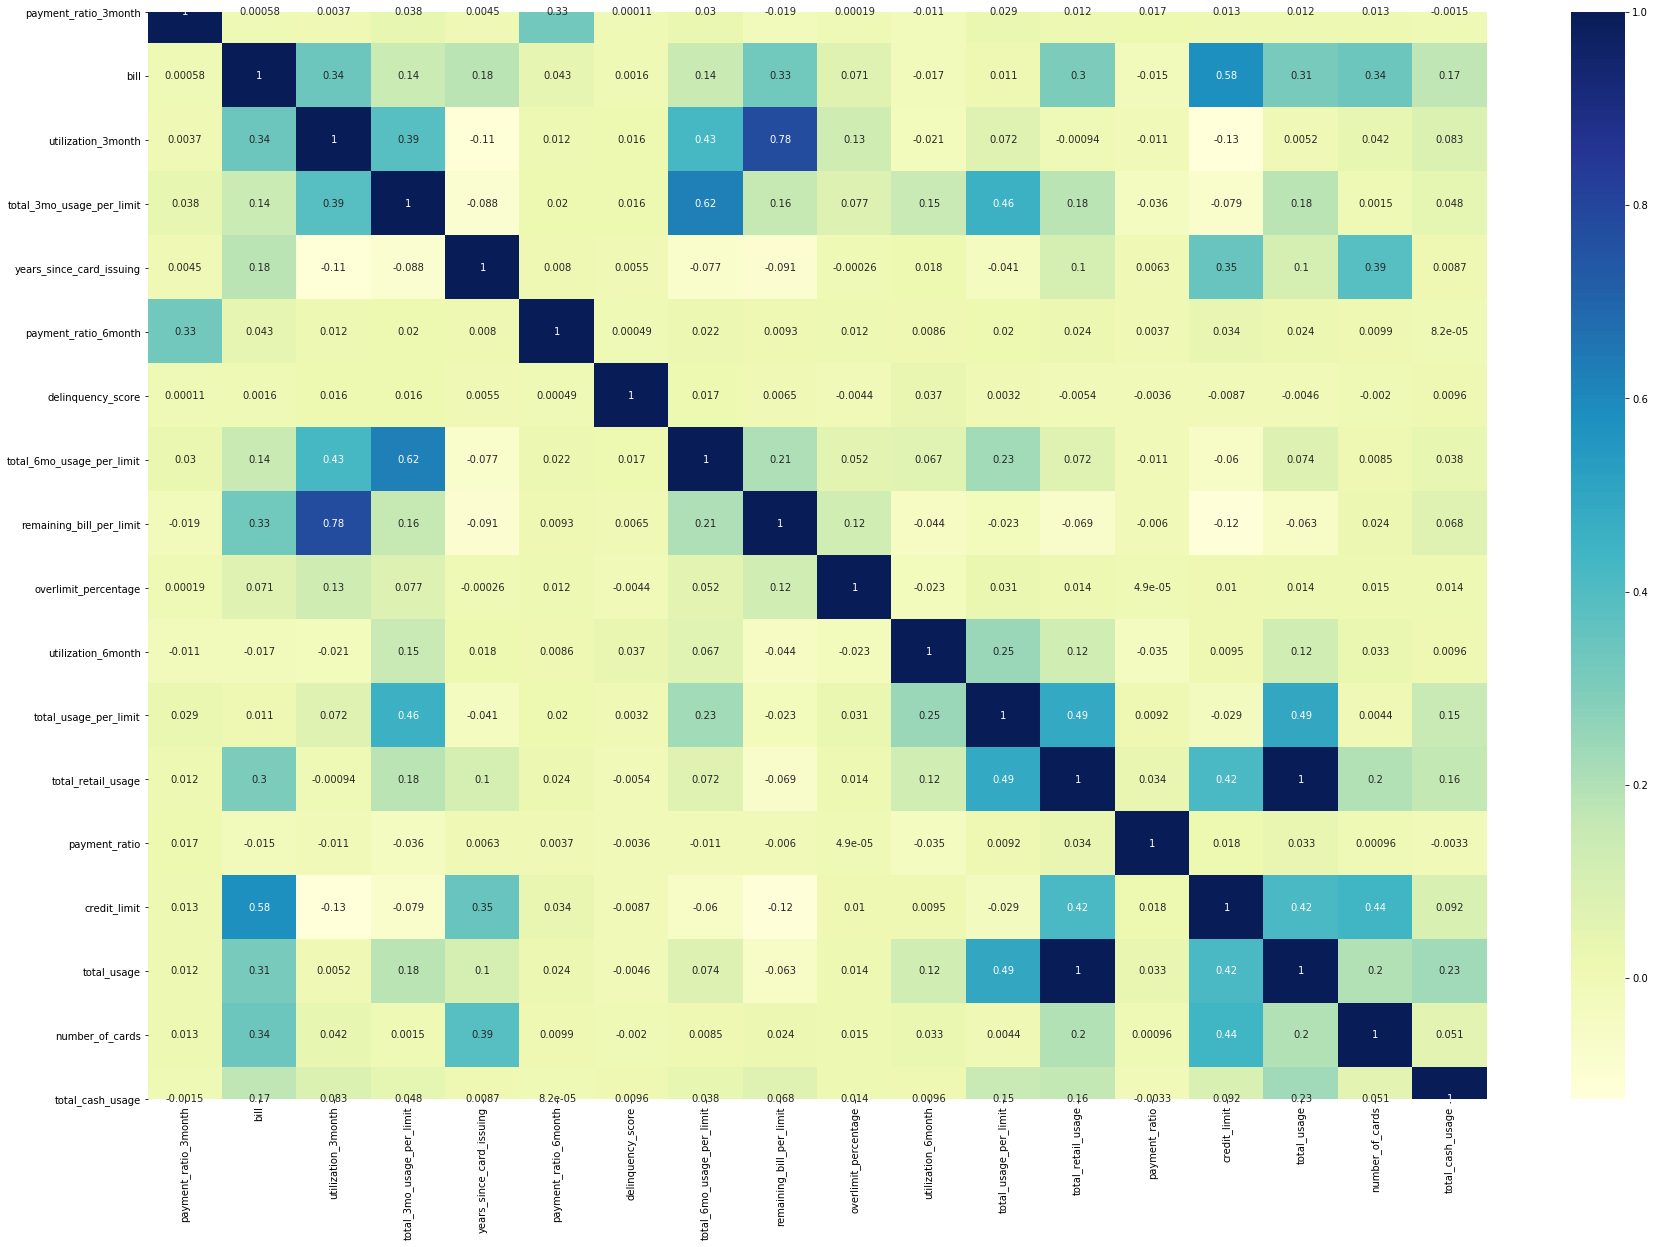

In [21]:
# calculate pair-wise correlations between them
corrmat = train[selected_features_raw_value].corr()
plt.figure(figsize=(30,20))
sns.heatmap(corrmat, annot=True, cmap="YlGnBu")

In [22]:
selected_features_by_woe = [
    'payment_ratio',
    'total_retail_usage',
    #  'total_usage',
    'payment_ratio_3month',
    #  'total_usage_per_limit',
    'utilization_3month',
    #  'bill',
    'outstanding',
    'utilization_6month',
    'payment_ratio_6month',
    'total_3mo_usage_per_limit',
    #  'remaining_bill_per_limit',
    'overlimit_percentage',
    'remaining_bill_per_number_of_cards',
    #  'remaining_bill',
    'total_6mo_usage_per_limit'
]
len(selected_features_by_woe)

11

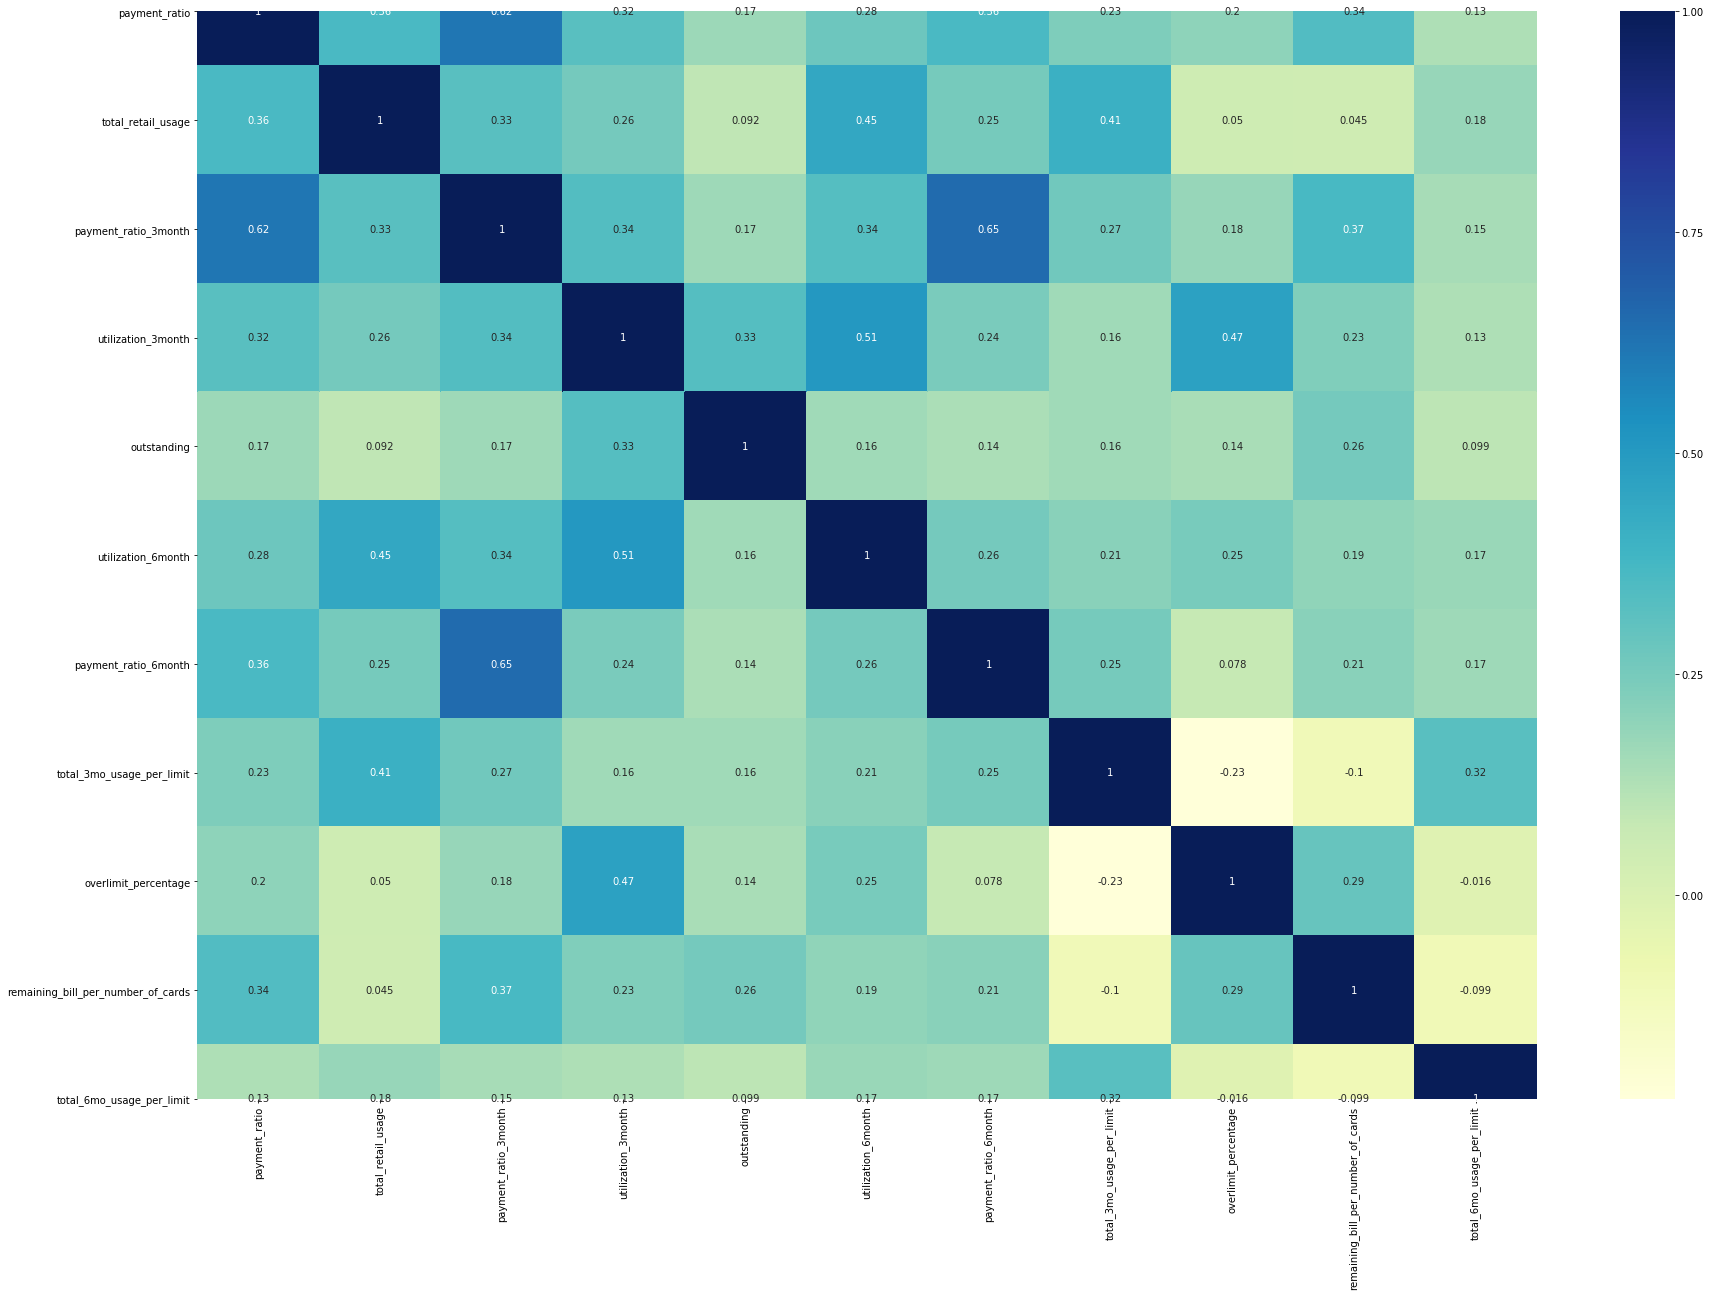

In [23]:
# calculate pair-wise correlations between them
corrmat = data_woe[selected_features_by_woe].corr()
plt.figure(figsize=(30,20))
sns.heatmap(corrmat, annot=True, cmap="YlGnBu")

# Save

In [24]:
bb.save_meta_data_to_file('../data/feature_meta_data.csv')

In [25]:
train.to_csv('../data/train.csv', index=False)
test.to_csv('../data/test.csv', index=False)